In [1]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

df = pd.read_table('/kaggle/input/cancer-data/CY_all_sample_taxa.tsv', sep='\t')
aggregated_df3 = pd.read_csv('/kaggle/input/aggregated-df/final (1).csv')
final_df3 = pd.read_csv('/kaggle/input/final-df/final.csv')

# Preprocessing

In [2]:
blood = df["sample"].apply(lambda x: False if (x.endswith("N") or x.endswith("N.A") or x.endswith("Nm")) 
                               else True if (x.endswith("P") or x.endswith("P.A") or x.endswith("Pm")) else None).astype(bool)
df["blood"] = blood

columns_to_exclude = ["sample", "blood", "diagnosis", "Gender", "Age"]
df_bact = df.drop(columns_to_exclude, axis=1)

# Functions

In [3]:
import matplotlib.pyplot as plt
def zero_bar(df):
    # Calculate the frequency of zeros in each column
    zero_freq = (df == 0).sum()

    # Create a bar plot of zero frequencies
    plt.bar(range(len(zero_freq)), zero_freq)
    plt.title("Frequency of Zeros")
    plt.xlabel("Columns")
    plt.ylabel("Frequency")
    plt.xticks([])
    plt.show()

In [4]:
def col_aggregator(df,gencol):
    aggregated_df = pd.DataFrame(columns=new_gen[gencol].unique())

    for index, row in df.iterrows():
        row_sum = []

        for column in new_gen[gencol].unique():
            agg_cols = new_gen.loc[new_gen[gencol] == column, 'Column']

            # Get the sum of all columns from agg_cols at every row
            sum_value = row[agg_cols].sum()
            row_sum.append(sum_value)

        # Add the row_sum values to the aggregated_df dataframe
        aggregated_df.loc[index] = row_sum
        
    return aggregated_df

In [5]:
def df_prep(aggregated_df,df,columns_to_exclude):
    columns_with_zeros = aggregated_df.columns[aggregated_df.eq(0).sum() > 0.90 * len(aggregated_df)]
    normal_df = aggregated_df.drop(columns_with_zeros, axis=1)
    
    # Normalize values across rows
    normal_df = normal_df.div(normal_df.sum(axis=1), axis=0)
    
    final_df = pd.concat([normal_df, df[columns_to_exclude]], axis=1)
    final_df[normal_df.columns] = final_df[normal_df.columns].astype('float')
    final_df = final_df.drop("sample",axis = 1)
    
    return final_df

In [6]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def logistic_regression_with_nested_cv(dataframe):
    # Separate features and target variable
    X = dataframe.drop(['diagnosis','Age','Gender','blood'], axis=1)
    y = dataframe['diagnosis']

    # Define the parameter grid for Logistic regression
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10,100,400,1000]}

    # Initialize Lasso regression model
    logistic_model = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1')

    # Perform nested cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True)
    best_score = 0
    best_model = None

    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train)

        score = grid_search.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_model = grid_search.best_estimator_

    # Compute confusion matrix using the best model
    predicted = best_model.predict(X)
    confusion_mat = confusion_matrix(y, predicted)

    return best_model,confusion_mat

In [7]:
def get_feature_importance(model, dataframe):
    # Separate features and target variable
    X = dataframe.drop(['diagnosis','Age','Gender','blood'], axis=1)
    y = dataframe['diagnosis']

    # Get regression coefficients
    coefficients = model.coef_[0]

    # Create a pandas Series with coefficients and feature names
    feature_importance = pd.Series(coefficients, index=X.columns)

    return feature_importance

# Getting the phylogenetic tree

In [8]:
new_gen = pd.DataFrame(columns = ['Column','D0','D1','D2','D3','D4','D5'])
for i in range(0,len(df_bact.columns)):
    col_name = df_bact.columns[i]
    first_spl = col_name.split("D_")
    new_gen.loc[i, 'Column'] = col_name
    for j in range(1,len(first_spl)):
        sec_spl = first_spl[j].split("__")
        d = sec_spl[1][0:-1]
        new_gen.loc[i, 'D'+str(j-1)] = d

In [9]:
aggregated_df2 = col_aggregator(df_bact,'D2')

In [10]:
aggregated_df3 = col_aggregator(df_bact,'D3')

In [11]:
aggregated_df4 = col_aggregator(df_bact,'D4')

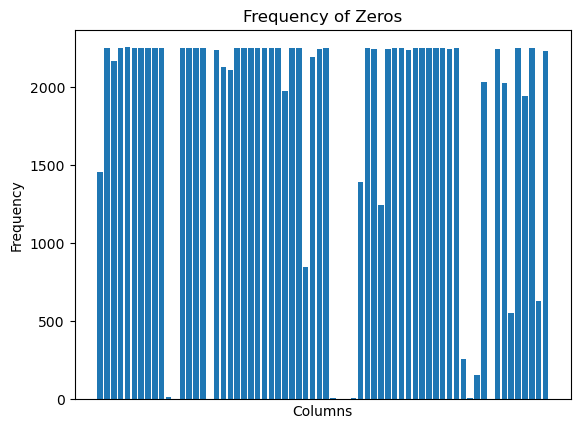

In [12]:
zero_bar(aggregated_df2)

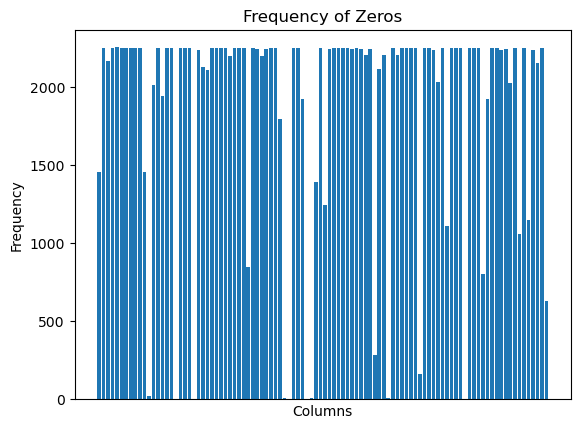

In [13]:
zero_bar(aggregated_df3)

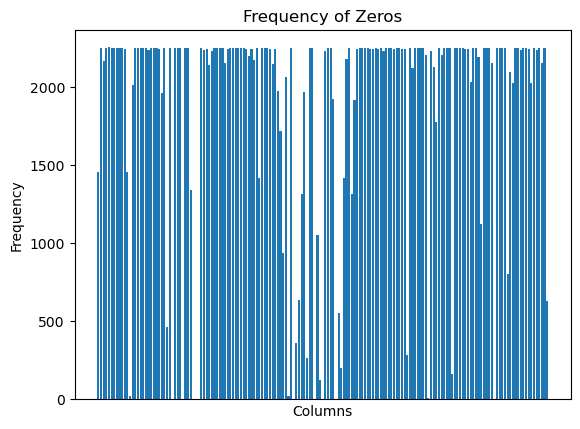

In [14]:
zero_bar(aggregated_df4)

In [15]:
final_df2 = df_prep(aggregated_df2,df,columns_to_exclude)
#aggregated_df2 = final_df2.drop(['blood','Age','Gender','diagnosis'], axis=1).copy()
final_df3 = df_prep(aggregated_df3,df,columns_to_exclude)
#aggregated_df3 = final_df3.drop(['blood','Age','Gender','diagnosis'], axis=1).copy()
final_df4 = df_prep(aggregated_df4,df,columns_to_exclude)
#aggregated_df4 = final_df4.drop(['blood','Age','Gender','diagnosis'], axis=1).copy()

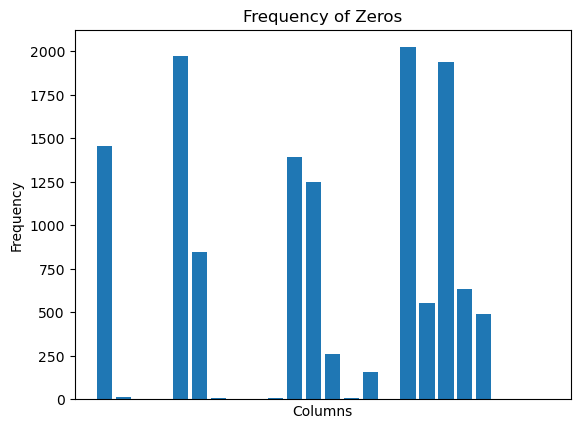

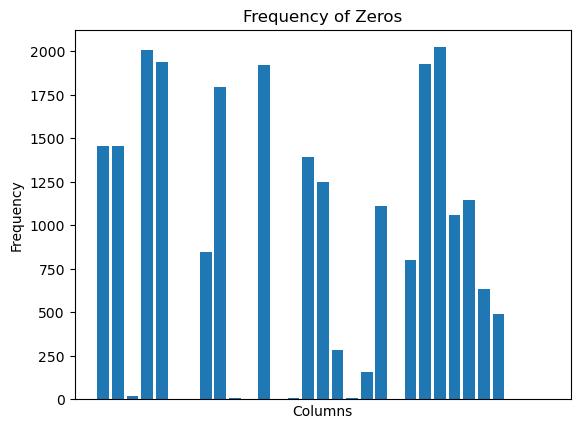

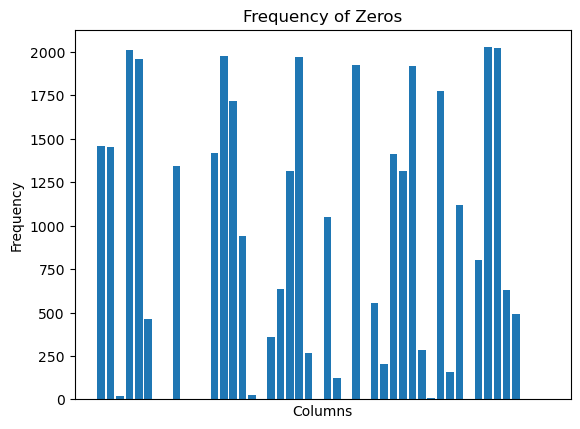

In [16]:
zero_bar(final_df2)
zero_bar(final_df3)
zero_bar(final_df4)

In [17]:
final_df4

,Methanobacteriaceae,Actinomycetaceae,Bifidobacteriaceae,Corynebacteriaceae,Micrococcaceae,uncultured bacterium,Coriobacteriaceae,Bacteroidaceae,Bacteroidales S24-7 group,Porphyromonadaceae,...,Succinivibrionaceae,Enterobacteriaceae,Pasteurellaceae,Pseudomonadaceae,Synergistaceae,Verrucomicrobiaceae,blood,diagnosis,Gender,Age
0,0.000291,0.000169,0.002138,0.000000,0.000000,0.000028,0.010810,0.031427,0.018179,0.053093,...,0.024292,0.003356,0.000253,0.000000,0.0,0.000244,True,normal_colonoscopy,Male,60
1,0.000000,0.000260,0.019089,0.000016,0.000000,0.000027,0.009355,0.151326,0.000000,0.041446,...,0.000087,0.001407,0.000292,0.000000,0.0,0.000054,False,negative,Female,64
2,0.000000,0.000000,0.006306,0.000000,0.000000,0.000082,0.001446,0.370204,0.000082,0.056914,...,0.000062,0.106603,0.000171,0.000000,0.0,0.000110,True,cancer,Male,64
3,0.000000,0.000148,0.021613,0.000000,0.000000,0.000000,0.010228,0.231773,0.000000,0.024739,...,0.000026,0.001002,0.000083,0.000000,0.0,0.000103,False,negative,Female,60
4,0.000000,0.000131,0.072160,0.000000,0.000000,0.000074,0.036654,0.166134,0.000107,0.029303,...,0.000000,0.126596,0.001967,0.000000,0.0,0.000188,True,normal_colonoscopy,Female,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.000000,0.000235,0.070753,0.000089,0.000203,0.000083,0.024788,0.151381,0.000000,0.009094,...,0.000114,0.002645,0.003072,0.000000,0.0,0.000127,True,normal_colonoscopy,Male,62
2248,0.001741,0.000000,0.012427,0.000000,0.000000,0.000122,0.010640,0.169940,0.000758,0.039247,...,0.000047,0.001713,0.000870,0.000000,0.0,0.000112,True,normal_colonoscopy,Female,62
2249,0.000665,0.000077,0.000775,0.000000,0.000000,0.002286,0.005927,0.146700,0.075823,0.011595,...,0.000071,0.001304,0.000084,0.000077,0.0,0.000413,False,negative,Male,69
2250,0.002398,0.000043,0.042919,0.000000,0.000000,0.015256,0.015563,0.225362,0.000043,0.000469,...,0.000051,0.042125,0.000000,0.000000,0.0,0.097450,True,normal_colonoscopy,Female,60


In [18]:
import numpy as np
from scipy.stats import t

def find_significant_correlations(corr_matrix, threshold=0.05):
    # Get the number of variables
    num_variables = corr_matrix.shape[0]
    
    # Create an empty list to store significant correlations
    significant_correlations = []
    
    # Iterate over each variable
    for i in range(num_variables):
        for j in range(i + 1, num_variables):
            # Perform hypothesis testing (Pearson correlation test)
            corr = corr_matrix.iloc[i, j]
            p_value = calculate_p_value(corr, len(corr_matrix))
            
            # Check if the correlation is significant
            if p_value < threshold:
                # Store the significant correlation and the variables involved
                variable1 = corr_matrix.index[i]
                variable2 = corr_matrix.columns[j]
                significant_correlations.append((variable1, variable2, corr, p_value))
    
    return significant_correlations

def calculate_p_value(correlation, sample_size):
    # Perform two-tailed t-test and calculate the p-value
    # based on the correlation coefficient, sample size, and degrees of freedom
    df = sample_size - 2  # degrees of freedom
    t_value = correlation * np.sqrt(df / (1 - correlation**2))
    p_value = 2 * (1 - t.cdf(abs(t_value), df))
    
    return p_value

traverse_list = [final_df2.drop(['diagnosis','Gender'], axis = 1),final_df3.drop(['diagnosis','Gender'], axis = 1),final_df4.drop(['diagnosis','Gender'], axis = 1)]
for i in range(0,len(traverse_list)):
    print ("Stats for D"+str(i+2))
    significant_correlations = find_significant_correlations(traverse_list[i].corr())

    # Print the significant correlations
    for var1, var2, corr, p_value in significant_correlations:
        print(f"{var1} - {var2}: correlation = {corr:.2f}, p-value = {p_value:.4f}")
    print ("\n")

Stats for D2
Bacteroidia - Clostridia: correlation = -0.62, p-value = 0.0019
Clostridia - Gammaproteobacteria: correlation = -0.44, p-value = 0.0430


Stats for D3
Methanobacteriales - Thermoanaerobacterales: correlation = 0.42, p-value = 0.0250
Bacteroidales - Clostridiales: correlation = -0.63, p-value = 0.0003
Clostridiales - Enterobacteriales: correlation = -0.43, p-value = 0.0214
Thermoanaerobacterales - Synergistales: correlation = 0.44, p-value = 0.0167


Stats for D4
Methanobacteriaceae - Christensenellaceae: correlation = 0.49, p-value = 0.0006
Methanobacteriaceae - Family XIII: correlation = 0.33, p-value = 0.0252
Methanobacteriaceae - Thermoanaerobacteraceae: correlation = 0.42, p-value = 0.0038
Methanobacteriaceae - Synergistaceae: correlation = 0.35, p-value = 0.0178
Actinomycetaceae - Family XI: correlation = 0.54, p-value = 0.0001
Bacteroidaceae - Prevotellaceae: correlation = -0.44, p-value = 0.0021
Bacteroidaceae - Ruminococcaceae: correlation = -0.31, p-value = 0.0345

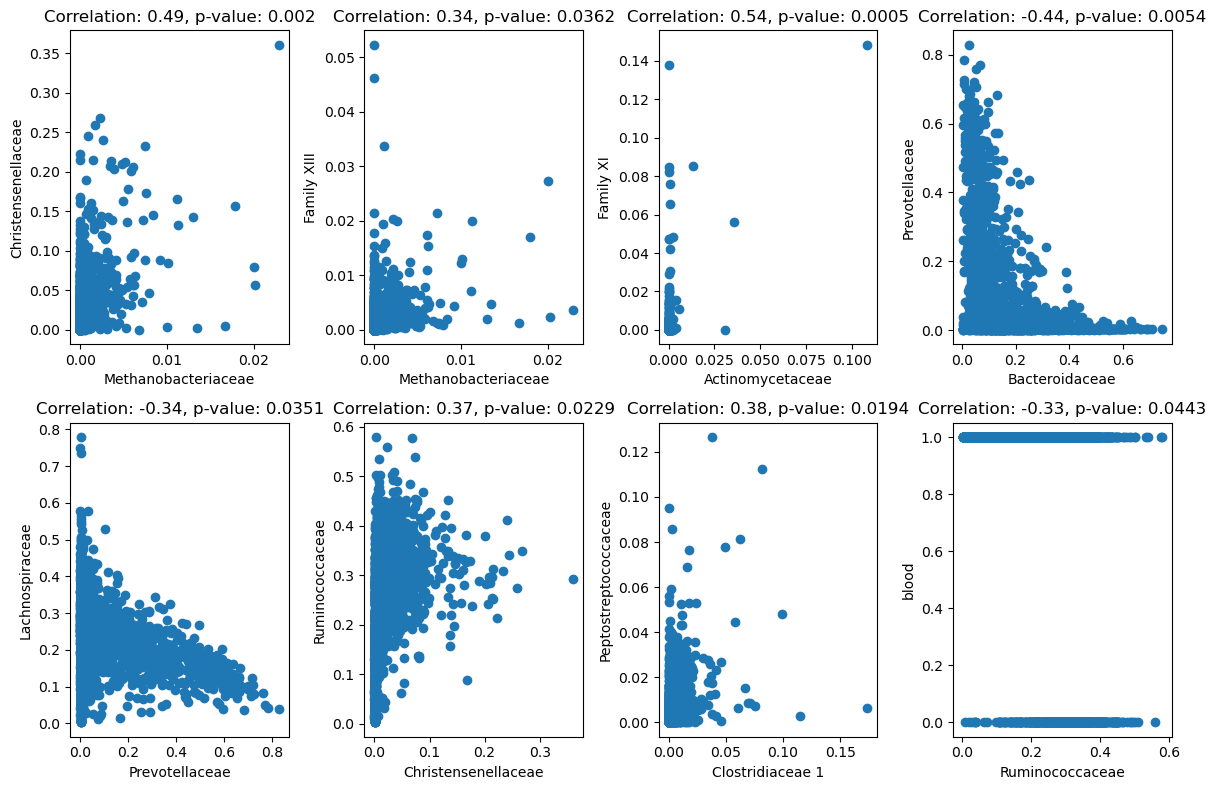

In [19]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Define the correlation and p-value values
correlations = [0.49, 0.34, 0.54, -0.44, -0.34, 0.37, 0.38, -0.33]
p_values = [0.0020, 0.0362, 0.0005, 0.0054, 0.0351, 0.0229, 0.0194, 0.0443]

# Plot Methanobacteriaceae vs. Christensenellaceae
plt.subplot(241)
plt.scatter(final_df4['Methanobacteriaceae'], final_df4['Christensenellaceae'])
plt.xlabel('Methanobacteriaceae')
plt.ylabel('Christensenellaceae')
plt.title(f'Correlation: {correlations[0]}, p-value: {p_values[0]}')

# Plot Methanobacteriaceae vs. Family XIII
plt.subplot(242)
plt.scatter(final_df4['Methanobacteriaceae'], final_df4['Family XIII'])
plt.xlabel('Methanobacteriaceae')
plt.ylabel('Family XIII')
plt.title(f'Correlation: {correlations[1]}, p-value: {p_values[1]}')

# Plot Actinomycetaceae vs. Family XI
plt.subplot(243)
plt.scatter(final_df4['Actinomycetaceae'], final_df4['Family XI'])
plt.xlabel('Actinomycetaceae')
plt.ylabel('Family XI')
plt.title(f'Correlation: {correlations[2]}, p-value: {p_values[2]}')

# Plot Bacteroidaceae vs. Prevotellaceae
plt.subplot(244)
plt.scatter(final_df4['Bacteroidaceae'], final_df4['Prevotellaceae'])
plt.xlabel('Bacteroidaceae')
plt.ylabel('Prevotellaceae')
plt.title(f'Correlation: {correlations[3]}, p-value: {p_values[3]}')

# Plot Prevotellaceae vs. Lachnospiraceae
plt.subplot(245)
plt.scatter(final_df4['Prevotellaceae'], final_df4['Lachnospiraceae'])
plt.xlabel('Prevotellaceae')
plt.ylabel('Lachnospiraceae')
plt.title(f'Correlation: {correlations[4]}, p-value: {p_values[4]}')

# Plot Christensenellaceae vs. Ruminococcaceae
plt.subplot(246)
plt.scatter(final_df4['Christensenellaceae'], final_df4['Ruminococcaceae'])
plt.xlabel('Christensenellaceae')
plt.ylabel('Ruminococcaceae')
plt.title(f'Correlation: {correlations[5]}, p-value: {p_values[5]}')

# Plot Clostridiaceae 1 vs. Peptostreptococcaceae
plt.subplot(247)
plt.scatter(final_df4['Clostridiaceae 1'], final_df4['Peptostreptococcaceae'])
plt.xlabel('Clostridiaceae 1')
plt.ylabel('Peptostreptococcaceae')
plt.title(f'Correlation: {correlations[6]}, p-value: {p_values[6]}')

# Plot Ruminococcaceae vs. blood
plt.subplot(248)
plt.scatter(final_df4['Ruminococcaceae'], final_df4['blood'])
plt.xlabel('Ruminococcaceae')
plt.ylabel('blood')
plt.title(f'Correlation: {correlations[7]}, p-value: {p_values[7]}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
d4_cols = ['Methanobacteriaceae','Christensenellaceae','Family XIII','Actinomycetaceae','Family XI','Bacteroidaceae','Prevotellaceae','Lachnospiraceae','Christensenellaceae','Ruminococcaceae','Clostridiaceae 1','Peptostreptococcaceae','Ruminococcaceae','blood']

In [21]:
new_gen[new_gen['D4'].isin(d4_cols)]['D4']

0      Methanobacteriaceae
1      Methanobacteriaceae
16        Actinomycetaceae
17        Actinomycetaceae
18        Actinomycetaceae
              ...         
359        Ruminococcaceae
360        Ruminococcaceae
361        Ruminococcaceae
362        Ruminococcaceae
363        Ruminococcaceae
Name: D4, Length: 155, dtype: object

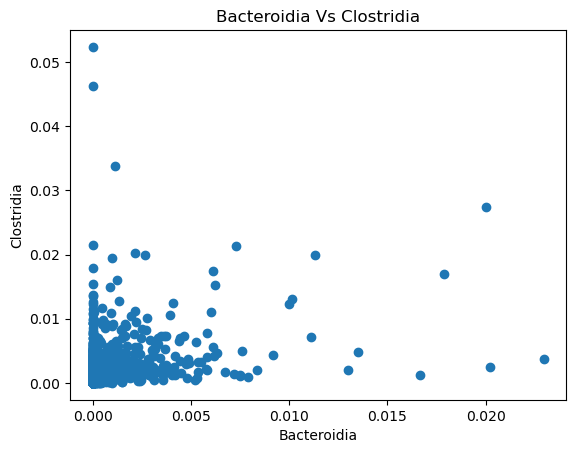

In [22]:
plt.scatter(final_df4['Methanobacteriaceae'],final_df4['Family XIII'])
plt.xlabel('Bacteroidia')
plt.ylabel('Clostridia')
plt.title('Bacteroidia Vs Clostridia')

# Show the plot
plt.show()

In [23]:
#aggregated_df.to_csv('final.csv', index=False)

In [24]:
import umap.umap_ as umap
import numpy as np
def plot_with_color_coding(df, column):
    # Perform dimensionality reduction with UMAP
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(df.drop(column, axis=1).values)
    
    # Get unique values from the specified column
    unique_values = df[column].unique()
    
    # Assign a unique color to each unique value
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_values)))
    color_mapping = dict(zip(unique_values, colors))
    
    # Create a scatter plot with color coding
    fig, ax = plt.subplots()
    for value in unique_values:
        indices = df[column] == value
        ax.scatter(embedding[indices, 0], embedding[indices, 1], color=color_mapping[value], label=value)
    
    # Add legend
    ax.legend(loc='best')
    
    # Show the plot
    plt.show()

def reduce_dimensions_and_plot(df):
    # Perform dimensionality reduction with UMAP
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(df.values)

    # Plot the reduced dimensions
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('UMAP Dimensionality Reduction')

    # Show the plot
    plt.show()

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

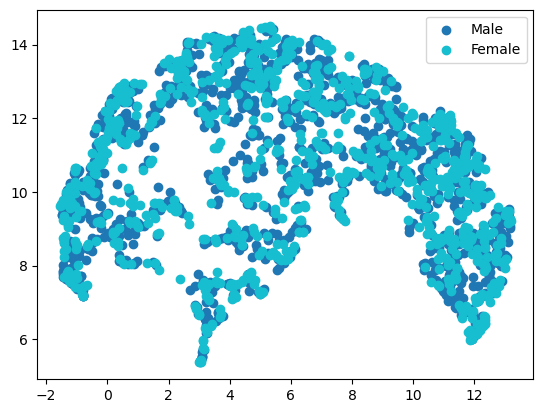

In [25]:
plot_with_color_coding(final_df2.drop(['blood','diagnosis','Age'], axis=1).copy(),'Gender')

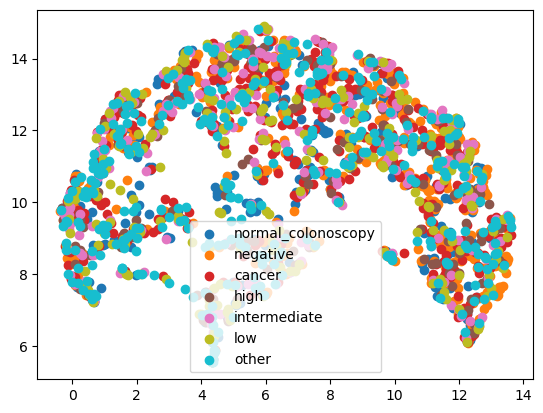

In [26]:
plot_with_color_coding(final_df3.drop(['blood','Gender','Age'], axis=1).copy(),'diagnosis')

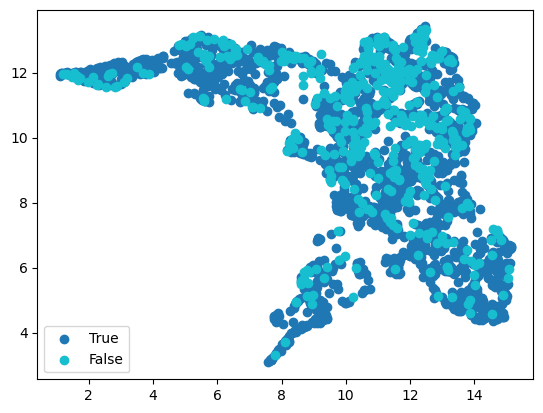

In [27]:
plot_with_color_coding(final_df4.drop(['Age','Gender','diagnosis'], axis=1).copy(),'blood')

### Try to perform clustering and then plot cancer heatmap

In [28]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_ideal_num_clusters(dataframe):
    wcss_scores = []
    max_clusters = 25

    for num_clusters in range(2, max_clusters + 1):
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=num_clusters, n_init = 'auto')
        kmeans.fit(dataframe)

        # Calculate the within-cluster sum of squares (WCSS)
        wcss = kmeans.inertia_
        wcss_scores.append(wcss)

    return wcss_scores


def perform_kmeans_clustering(dataframe, num_clusters):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, n_init = 'auto')
    labels = kmeans.fit_predict(dataframe)

    # Add the cluster labels to the dataframe
    dataframe['Cluster'] = labels

    return dataframe

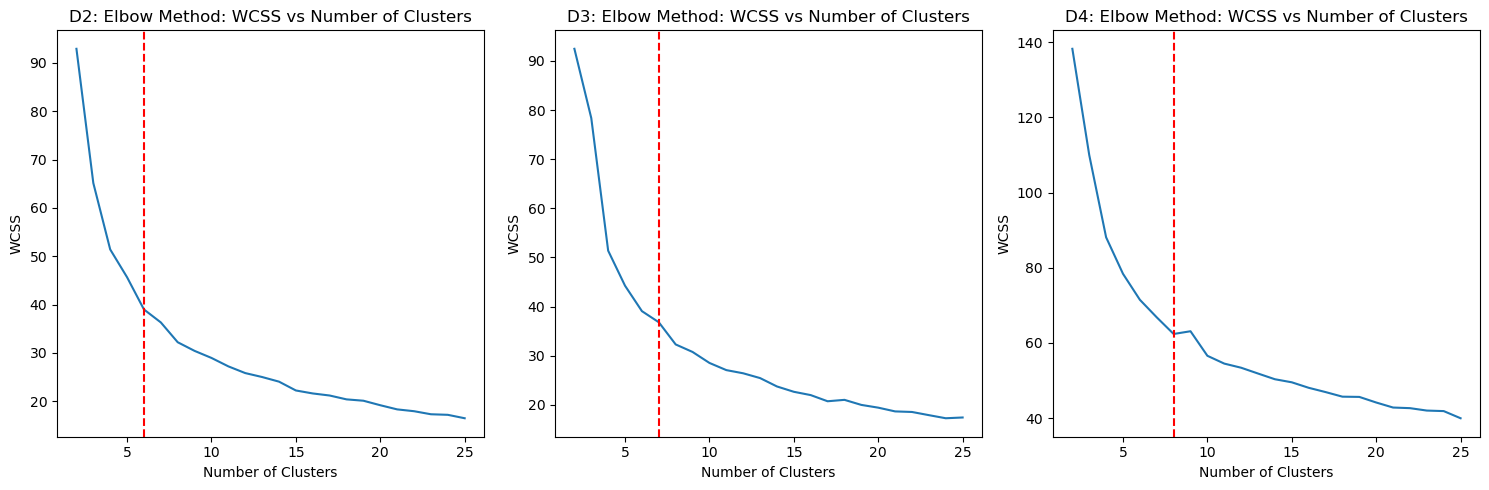

In [29]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for aggregated_df2
scores = find_ideal_num_clusters(final_df2.drop(['blood','Age','Gender','diagnosis'], axis=1).copy())
axs[0].plot(range(2, 25 + 1), scores)
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('WCSS')
axs[0].set_title('D2: Elbow Method: WCSS vs Number of Clusters')
axs[0].axvline(x=6, color='red', linestyle='--')

# Plot for aggregated_df3
scores = find_ideal_num_clusters(final_df3.drop(['blood','Age','Gender','diagnosis'], axis=1).copy())
axs[1].plot(range(2, 25 + 1), scores)
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('WCSS')
axs[1].set_title('D3: Elbow Method: WCSS vs Number of Clusters')
axs[1].axvline(x=7, color='red', linestyle='--')

# Plot for aggregated_df4
scores = find_ideal_num_clusters(final_df4.drop(['blood','Age','Gender','diagnosis'], axis=1).copy())
axs[2].plot(range(2, 25 + 1), scores)
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('WCSS')
axs[2].set_title('D4: Elbow Method: WCSS vs Number of Clusters')
axs[2].axvline(x=8, color='red', linestyle='--')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

6,7 and 8 clusters is best

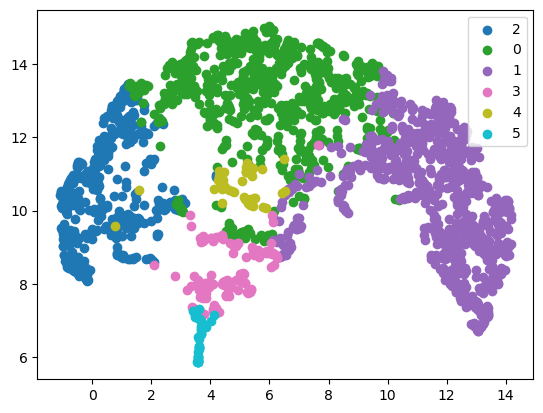

In [30]:
clustered_df2 = perform_kmeans_clustering(final_df2.drop(['blood','Age','Gender','diagnosis'], axis=1).copy(),6)
plot_with_color_coding(clustered_df2,'Cluster')

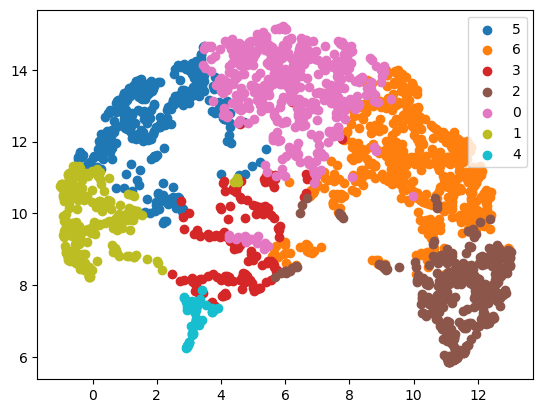

In [31]:
clustered_df3 = perform_kmeans_clustering(final_df3.drop(['blood','Age','Gender','diagnosis'], axis=1).copy(),7)
plot_with_color_coding(clustered_df3,'Cluster')

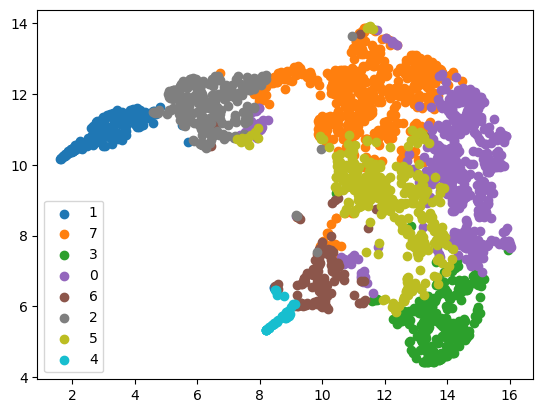

In [32]:
clustered_df4 = perform_kmeans_clustering(final_df4.drop(['blood','Age','Gender','diagnosis'], axis=1).copy(),8)
plot_with_color_coding(clustered_df4,'Cluster')

try cancer heatmap

In [33]:
clustered_df2

,Methanobacteria,Actinobacteria,Coriobacteriia,Bacteroidia,Chloroplast,Melainabacteria,Bacilli,Clostridia,Erysipelotrichia,Negativicutes,...,Lentisphaeria,Alphaproteobacteria,Betaproteobacteria,Deltaproteobacteria,Gammaproteobacteria,Synergistia,Mollicutes,Opitutae,Verrucomicrobiae,Cluster
0,0.000290,0.002304,0.010797,0.547653,0.000375,0.000028,0.001592,0.344305,0.025479,0.009476,...,0.000384,0.001714,0.023391,0.003652,0.027867,0.0,0.000403,0.000000,0.000243,2
1,0.000000,0.019058,0.009207,0.326885,0.000000,0.000027,0.000666,0.586491,0.003616,0.006571,...,0.000458,0.000154,0.017545,0.011853,0.001757,0.0,0.015660,0.000000,0.000053,0
2,0.000000,0.006297,0.001444,0.474016,0.000910,0.000082,0.006776,0.342498,0.022196,0.023222,...,0.000000,0.000561,0.014058,0.001027,0.106674,0.0,0.000116,0.000014,0.000110,2
3,0.000000,0.021752,0.010225,0.289591,0.000000,0.000000,0.003049,0.633900,0.012163,0.003935,...,0.000077,0.008261,0.011919,0.003781,0.001110,0.0,0.000135,0.000000,0.000103,1
4,0.000000,0.072280,0.036648,0.217455,0.000000,0.000049,0.002769,0.423750,0.004981,0.068995,...,0.000041,0.000066,0.042375,0.001630,0.128543,0.0,0.000180,0.000000,0.000188,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.000000,0.071235,0.024772,0.171188,0.000000,0.000083,0.012551,0.664919,0.012748,0.025808,...,0.000013,0.000330,0.008535,0.001659,0.005828,0.0,0.000146,0.000000,0.000127,1
2248,0.001698,0.012122,0.010378,0.241336,0.000110,0.000119,0.005969,0.651314,0.024864,0.003441,...,0.000000,0.019570,0.001588,0.000383,0.002565,0.0,0.024435,0.000000,0.000110,1
2249,0.000663,0.000850,0.005910,0.255736,0.000000,0.000296,0.001661,0.715192,0.006495,0.000315,...,0.000000,0.000109,0.004043,0.002099,0.001532,0.0,0.004686,0.000000,0.000412,1
2250,0.002398,0.042961,0.015563,0.272488,0.000000,0.000000,0.003865,0.474129,0.025384,0.002073,...,0.000000,0.000239,0.004966,0.001050,0.042176,0.0,0.015256,0.000000,0.097450,0


In [34]:
clustered_df3

,Methanobacteriales,Actinomycetales,Bifidobacteriales,Corynebacteriales,Micrococcales,Coriobacteriales,Bacteroidales,Gastranaerophilales,Bacillales,Lactobacillales,...,Desulfovibrionales,Aeromonadales,Enterobacteriales,Pasteurellales,Pseudomonadales,Synergistales,Mollicutes RF9,NB1-n,Verrucomicrobiales,Cluster
0,0.000291,0.000169,0.002137,0.000000,0.000000,0.010806,0.548131,0.000028,0.000000,0.001593,...,0.003655,0.024283,0.003355,0.000253,0.000000,0.0,0.000000,0.000075,0.000244,5
1,0.000000,0.000256,0.018787,0.000016,0.000000,0.009207,0.326911,0.000000,0.000133,0.000533,...,0.011854,0.000085,0.001385,0.000288,0.000000,0.0,0.000000,0.015608,0.000053,6
2,0.000000,0.000000,0.006306,0.000000,0.000000,0.001446,0.474705,0.000082,0.000000,0.006786,...,0.001028,0.000062,0.106596,0.000171,0.000000,0.0,0.000000,0.000069,0.000110,5
3,0.000000,0.000148,0.021606,0.000000,0.000000,0.010225,0.289608,0.000000,0.000000,0.003049,...,0.003781,0.000026,0.001001,0.000083,0.000000,0.0,0.000000,0.000077,0.000103,6
4,0.000000,0.000131,0.072155,0.000000,0.000000,0.036651,0.217474,0.000049,0.000000,0.002770,...,0.001631,0.000000,0.126588,0.001967,0.000000,0.0,0.000025,0.000066,0.000188,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.000000,0.000235,0.070712,0.000089,0.000203,0.024774,0.171199,0.000083,0.000000,0.012552,...,0.001659,0.000114,0.002644,0.003070,0.000000,0.0,0.000000,0.000083,0.000127,2
2248,0.001739,0.000000,0.012416,0.000000,0.000000,0.010630,0.247193,0.000122,0.000000,0.006114,...,0.000393,0.000047,0.001711,0.000869,0.000000,0.0,0.000000,0.000869,0.000112,6
2249,0.000663,0.000077,0.000772,0.000000,0.000000,0.005910,0.255736,0.000296,0.000000,0.001661,...,0.002099,0.000071,0.001300,0.000084,0.000077,0.0,0.002066,0.002620,0.000412,2
2250,0.002398,0.000043,0.042919,0.000000,0.000000,0.015563,0.272488,0.000000,0.000000,0.003865,...,0.001050,0.000051,0.042125,0.000000,0.000000,0.0,0.015256,0.000000,0.097450,0


In [35]:
clustered_df4

,Methanobacteriaceae,Actinomycetaceae,Bifidobacteriaceae,Corynebacteriaceae,Micrococcaceae,uncultured bacterium,Coriobacteriaceae,Bacteroidaceae,Bacteroidales S24-7 group,Porphyromonadaceae,...,Alcaligenaceae,Oxalobacteraceae,Desulfovibrionaceae,Succinivibrionaceae,Enterobacteriaceae,Pasteurellaceae,Pseudomonadaceae,Synergistaceae,Verrucomicrobiaceae,Cluster
0,0.000291,0.000169,0.002138,0.000000,0.000000,0.000028,0.010810,0.031427,0.018179,0.053093,...,0.023186,0.000234,0.003656,0.024292,0.003356,0.000253,0.000000,0.0,0.000244,1
1,0.000000,0.000260,0.019089,0.000016,0.000000,0.000027,0.009355,0.151326,0.000000,0.041446,...,0.017790,0.000000,0.012044,0.000087,0.001407,0.000292,0.000000,0.0,0.000054,7
2,0.000000,0.000000,0.006306,0.000000,0.000000,0.000082,0.001446,0.370204,0.000082,0.056914,...,0.014079,0.000000,0.001028,0.000062,0.106603,0.000171,0.000000,0.0,0.000110,3
3,0.000000,0.000148,0.021613,0.000000,0.000000,0.000000,0.010228,0.231773,0.000000,0.024739,...,0.011923,0.000000,0.003782,0.000026,0.001002,0.000083,0.000000,0.0,0.000103,0
4,0.000000,0.000131,0.072160,0.000000,0.000000,0.000074,0.036654,0.166134,0.000107,0.029303,...,0.042382,0.000000,0.001631,0.000000,0.126596,0.001967,0.000000,0.0,0.000188,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.000000,0.000235,0.070753,0.000089,0.000203,0.000083,0.024788,0.151381,0.000000,0.009094,...,0.008496,0.000045,0.001660,0.000114,0.002645,0.003072,0.000000,0.0,0.000127,0
2248,0.001741,0.000000,0.012427,0.000000,0.000000,0.000122,0.010640,0.169940,0.000758,0.039247,...,0.001628,0.000000,0.000393,0.000047,0.001713,0.000870,0.000000,0.0,0.000112,7
2249,0.000665,0.000077,0.000775,0.000000,0.000000,0.002286,0.005927,0.146700,0.075823,0.011595,...,0.004055,0.000000,0.002105,0.000071,0.001304,0.000084,0.000077,0.0,0.000413,7
2250,0.002398,0.000043,0.042919,0.000000,0.000000,0.015256,0.015563,0.225362,0.000043,0.000469,...,0.004966,0.000000,0.001050,0.000051,0.042125,0.000000,0.000000,0.0,0.097450,5


In [36]:
clustered_df4['Cluster'].value_counts()

7    576
0    493
5    338
3    254
2    239
1    175
6    136
4     41
Name: Cluster, dtype: int64

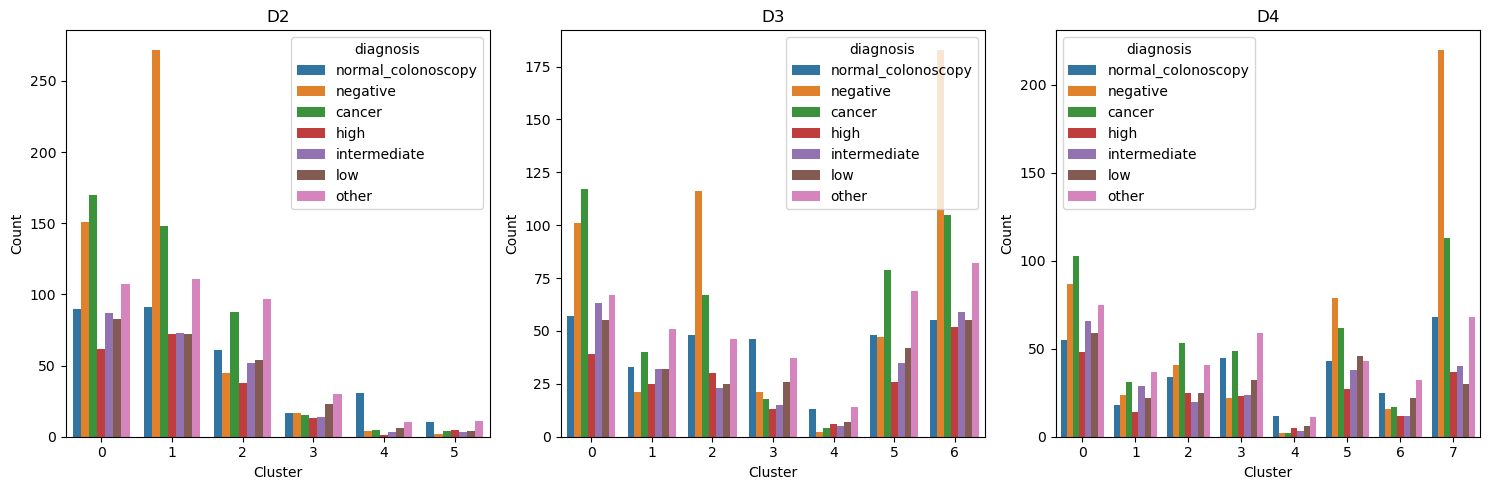

In [37]:
import seaborn as sns

def plot_countplot(dataframe, x_column, y_column, ax, title):
    sns.countplot(data=dataframe, x=x_column, hue=y_column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_column)
    ax.set_ylabel('Count')
    ax.legend(title=y_column)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_countplot(pd.concat([clustered_df2, final_df2['diagnosis']], axis=1), 'Cluster', 'diagnosis', axs[0],"D2")
plot_countplot(pd.concat([clustered_df3, final_df3['diagnosis']], axis=1), 'Cluster', 'diagnosis', axs[1],"D3")
plot_countplot(pd.concat([clustered_df4, final_df4['diagnosis']], axis=1), 'Cluster', 'diagnosis', axs[2],"D4")

plt.tight_layout()
plt.show()

In [38]:
# Assuming the categorical column is called 'gender'
#final_df3['Gender'] = final_df3['Gender'].map({'Male': True, 'Female': False})

# Assuming the categorical column is called 'gender'
#final_df['diagnosis'] = final_df['diagnosis'].map({'cancer': 1, 'negative': 2, 'high': 3, 'intermediate': 4, 'low': 5, 'other': 6, 'normal_colonoscopy': 7})

best_model2,confusion_matrix2 = logistic_regression_with_nested_cv(final_df2)
best_model3,confusion_matrix3 = logistic_regression_with_nested_cv(final_df3)
best_model4,confusion_matrix4 = logistic_regression_with_nested_cv(final_df4)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [39]:
get_feature_importance(best_model2, final_df2)

Methanobacteria        0.000000
Actinobacteria         0.000000
Coriobacteriia         0.000000
Bacteroidia            0.000000
Chloroplast            0.000000
Melainabacteria        0.000000
Bacilli                0.000000
Clostridia             0.219866
Erysipelotrichia       0.000000
Negativicutes          0.000000
Fusobacteriia          0.000000
Lentisphaeria          0.000000
Alphaproteobacteria    0.000000
Betaproteobacteria     0.000000
Deltaproteobacteria    0.000000
Gammaproteobacteria   -0.926401
Synergistia            0.000000
Mollicutes             0.000000
Opitutae               0.000000
Verrucomicrobiae       0.000000
dtype: float64

In [40]:
get_feature_importance(best_model3, final_df3)

Methanobacteriales        0.484835
Actinomycetales           0.000000
Bifidobacteriales        -2.533292
Corynebacteriales         0.000000
Micrococcales             0.000000
Coriobacteriales         -0.097243
Bacteroidales            -3.005186
Gastranaerophilales       0.326621
Bacillales                6.360121
Lactobacillales          -3.813627
Clostridiales            -2.894030
Thermoanaerobacterales    0.000000
Erysipelotrichales       -1.522864
Selenomonadales          -0.964901
Fusobacteriales           3.104116
Victivallales             6.802158
Rhodospirillales          1.568441
Burkholderiales          -4.709986
Desulfovibrionales       -0.871597
Aeromonadales            -0.568630
Enterobacteriales        -4.223990
Pasteurellales            0.296939
Pseudomonadales           1.603268
Synergistales             0.000000
Mollicutes RF9            2.998324
NB1-n                     2.435408
Verrucomicrobiales        1.738789
dtype: float64

In [41]:
get_feature_importance(best_model4, final_df4)

Methanobacteriaceae               0.000000
Actinomycetaceae                  0.000000
Bifidobacteriaceae               -0.378467
Corynebacteriaceae                0.000000
Micrococcaceae                    0.000000
uncultured bacterium              0.000000
Coriobacteriaceae                 0.000000
Bacteroidaceae                   -2.122312
Bacteroidales S24-7 group         0.045900
Porphyromonadaceae                1.507351
Prevotellaceae                   -0.767293
Rikenellaceae                     2.765621
Family XI                        10.852266
Carnobacteriaceae                 0.000000
Enterococcaceae                   0.000000
Lactobacillaceae                  0.000000
Streptococcaceae                 -4.184701
Christensenellaceae              -0.042447
Clostridiaceae 1                  0.000000
Clostridiales vadinBB60 group     5.890098
Defluviitaleaceae                 0.000000
Eubacteriaceae                    0.000000
Family XIII                       3.609609
Lachnospira

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(confusion_mat):
    # Calculate metrics
    accuracy = np.trace(confusion_mat) / np.sum(confusion_mat)
    precision = np.diag(confusion_mat) / np.sum(confusion_mat, axis=0)
    recall = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

## Neural Network

In [43]:
"""import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Separate features and target variable
X = final_df3.drop(['diagnosis','Age','Gender','blood'], axis=1).values
y = final_df3['diagnosis'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the target variable and transform the labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create training and testing datasets
train_dataset = CustomDataset(X_train, y_train_encoded)
test_dataset = CustomDataset(X_test, y_test_encoded)

# Define batch size
batch_size = 8

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of classes
num_classes = 7

# Instantiate the model
model = Net(input_size=36, num_classes=num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    
    accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}")
"""

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader, Dataset\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\n\nclass CustomDataset(Dataset):\n    def __init__(self, X, y):\n        self.X = torch.Tensor(X)\n        self.y = torch.LongTensor(y)\n    \n    def __len__(self):\n        return len(self.X)\n    \n    def __getitem__(self, idx):\n        return self.X[idx], self.y[idx]\n\n# Separate features and target variable\nX = final_df3.drop([\'diagnosis\',\'Age\',\'Gender\',\'blood\'], axis=1).values\ny = final_df3[\'diagnosis\'].values\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\n\n# Instantiate the LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Fit the LabelEncoder on the target variable and transform the labels\ny_train_encoded = label_encoder.fit_transform(y_trai

In [44]:
import re
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

def xgb_model(clean_data):
    # Perform nested cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

    best_score = None
    best_model = None
    
    # Define the parameter search space for Bayesian optimization
    param_space = {
        'eta': Real(0.01, 0.5),
        'learning_rate': Real(0.01, 0.5),
        'max_depth': Integer(3, 12),
        'subsample': Real(0.2, 1),
        'colsample_bytree': Real(0.5, 1),
        'lambda': Real(0.0, 10.0),
        'alpha': Real(0.0, 10.0),
        'gamma': Real(0.0, 10.0),
        'n_estimators': Integer(100, 500)
    }
    
    # Set parameters for LightGBM
    params = {
        "objective": "multi:softprob",
        "metric": "mlogloss",
        "num_class": len(clean_data["diagnosis"].unique()),
        "boosting_type": "gblinear",
        'verbosity': 0
    }
    
    # Create a mapping dictionary
    diagnosis_mapping = {diagnosis: index for index, diagnosis in enumerate(clean_data['diagnosis'].unique())}
    
    clean_data["diagnosis"] = clean_data["diagnosis"].map(diagnosis_mapping).astype(int)

    for train_index, test_index in outer_cv.split(clean_data.drop("diagnosis", axis=1), clean_data["diagnosis"]):
        train_data, test_data = clean_data.iloc[train_index], clean_data.iloc[test_index]

        # Perform Bayesian optimization with cross-validation
        opt = BayesSearchCV(
            estimator=xgb.XGBClassifier(),
            search_spaces=param_space,
            scoring="accuracy",
            n_iter=10,
            cv=inner_cv,
            verbose=False
        )

        # Fit the Bayesian optimization on the training data
        opt.fit(train_data.drop("diagnosis", axis=1).copy(), train_data["diagnosis"])

        # Get the best hyperparameters found
        best_params = opt.best_params_

        # Train the XGBoost model with the best hyperparameters
        xgb_model = xgb.XGBClassifier(**best_params)
        xgb_model.fit(train_data.drop("diagnosis", axis=1), train_data["diagnosis"])

        # Predict target variable for test data
        pred_test_xgb = xgb_model.predict(test_data.drop("diagnosis", axis=1))

        # Calculate accuracy
        acc = accuracy_score(test_data["diagnosis"], pred_test_xgb)

        # Calculate recall
        recall = recall_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate precision
        precision = precision_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate F1 score
        f1 = f1_score(test_data["diagnosis"], pred_test_xgb, average="weighted")

        # Calculate score using the formula
        score = 0.25 * acc + 0.25 * recall + 0.25 * precision + 0.25 * f1
        
        print("Score:", score, "\n")

        # Update the best score and best model if the current score is better
        if best_score is None or score > best_score:
            best_score = score
            best_model = xgb_model

    # Print the best score
    print("Best Score:", best_score, "\n")

    return best_score, best_model, diagnosis_mapping

def get_featimps_xg(model):
    # Get feature names
    feature_names = model.feature_names_in_

    # Get feature importances
    feature_importances = model.feature_importances_

    # Create a dictionary to store feature importance
    features = {}

    # Iterate over the feature names and importances
    for feature_name, importance in zip(feature_names, feature_importances):
        # Store the feature importance with the corresponding feature name
        features[feature_name] = importance

    # Sort the features by importance in descending order
    features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}

    return features

#features = get_featimps_xg(model, merged_df.drop("diagnosis", axis=1).columns)

# Display features in descending order of importance
#for feature, importance in features.items():
#    print(f"{feature}: {importance}")

In [45]:
score2, model2, labels2 = xgb_model(final_df2.drop(['Age','Gender','blood'],axis = 1))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.29252077793961034 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.2897552903834187 

Score: 0.28888627212032364 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.3114143387576719 

Score: 0.3011781745360322 

Best Score: 0.3114143387576719 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
score3, model3, labels3 = xgb_model(final_df3.drop(['Age','Gender','blood'],axis = 1))

Score: 0.2939578259836175 

Score: 0.3277062729412148 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.3248351191287531 

Score: 0.2910720135016599 

Score: 0.32561859020601164 

Best Score: 0.3277062729412148 



In [47]:
score4, model4, labels4 = xgb_model(final_df4.drop(['Age','Gender','blood'],axis = 1))

Score: 0.3639720816970627 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.33220023119653763 

Score: 0.34610320251532295 



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score: 0.29993072743707616 

Score: 0.3481361876808808 

Best Score: 0.3639720816970627 



In [48]:
get_featimps_xg(model2)

{'Fusobacteriia': 0.10385765,
 'Clostridia': 0.09772086,
 'Erysipelotrichia': 0.07219366,
 'Verrucomicrobiae': 0.067259185,
 'Mollicutes': 0.066120155,
 'Bacilli': 0.06227973,
 'Gammaproteobacteria': 0.06149357,
 'Negativicutes': 0.059309456,
 'Melainabacteria': 0.055876352,
 'Alphaproteobacteria': 0.05205791,
 'Actinobacteria': 0.046994746,
 'Methanobacteria': 0.046435226,
 'Deltaproteobacteria': 0.04598924,
 'Betaproteobacteria': 0.04568835,
 'Lentisphaeria': 0.040125225,
 'Bacteroidia': 0.0387044,
 'Coriobacteriia': 0.03789426,
 'Chloroplast': 0.0,
 'Synergistia': 0.0,
 'Opitutae': 0.0}

In [49]:
get_featimps_xg(model3)

{'Fusobacteriales': 0.122226395,
 'Corynebacteriales': 0.07943785,
 'NB1-n': 0.07535887,
 'Clostridiales': 0.07015203,
 'Bacillales': 0.047382064,
 'Verrucomicrobiales': 0.042006973,
 'Enterobacteriales': 0.04130492,
 'Lactobacillales': 0.040760417,
 'Mollicutes RF9': 0.039037965,
 'Actinomycetales': 0.03771462,
 'Micrococcales': 0.03686839,
 'Erysipelotrichales': 0.034334004,
 'Bifidobacteriales': 0.03310564,
 'Rhodospirillales': 0.03214802,
 'Aeromonadales': 0.028074883,
 'Victivallales': 0.026576186,
 'Thermoanaerobacterales': 0.025722075,
 'Desulfovibrionales': 0.025690766,
 'Selenomonadales': 0.025631666,
 'Gastranaerophilales': 0.024888426,
 'Bacteroidales': 0.024088401,
 'Burkholderiales': 0.024006832,
 'Methanobacteriales': 0.022083683,
 'Pasteurellales': 0.021251762,
 'Coriobacteriales': 0.020147247,
 'Pseudomonadales': 0.0,
 'Synergistales': 0.0}

In [50]:
get_featimps_xg(model4)

{'Family XI': 0.07017963,
 'Fusobacteriaceae': 0.06731518,
 'Clostridiales vadinBB60 group': 0.043716636,
 'Lactobacillaceae': 0.04211605,
 'Rikenellaceae': 0.039109014,
 'Ruminococcaceae': 0.035508685,
 'Bacteroidaceae': 0.0294057,
 'Verrucomicrobiaceae': 0.029054455,
 'Porphyromonadaceae': 0.028957054,
 'Christensenellaceae': 0.02679046,
 'Coriobacteriaceae': 0.0259824,
 'uncultured bacterium': 0.025954193,
 'Rhodospirillaceae': 0.025379604,
 'Succinivibrionaceae': 0.024974098,
 'Veillonellaceae': 0.024740407,
 'Erysipelotrichaceae': 0.02367371,
 'Lachnospiraceae': 0.023321128,
 'Streptococcaceae': 0.023020608,
 'Family XIII': 0.022504779,
 'Bifidobacteriaceae': 0.022265041,
 'Desulfovibrionaceae': 0.02210413,
 'Pasteurellaceae': 0.022001963,
 'Acidaminococcaceae': 0.021748397,
 'Enterobacteriaceae': 0.021706298,
 'Peptostreptococcaceae': 0.02158403,
 'Bacteroidales S24-7 group': 0.020599863,
 'Alcaligenaceae': 0.01981711,
 'Victivallaceae': 0.019132497,
 'Peptococcaceae': 0.01912150

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # Value not found in the dictionary


def plot_confusion_matrix_xg(model, dataframe, label_mapping,title):
    # Convert the string labels to integer labels
    dataframe["diagnosis"] = dataframe["diagnosis"].map(label_mapping).astype(int)

    # Separate features and target variable
    X = dataframe.drop("diagnosis", axis=1)
    y = dataframe["diagnosis"]

    # Predict target variable using the model
    y_pred = model.predict(X)

    # Create confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Get unique labels
    unique_labels = np.unique(y)

    # Convert integer labels back to string labels
    label_names = [get_key_from_value(label_mapping, label) for label in unique_labels]

    # Create heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
    
    return cm
    
def plot_confusion_matrix_log(model, dataframe, title):
    # Separate features and target variable
    X = dataframe.drop("diagnosis", axis=1)
    y = dataframe["diagnosis"]

    # Predict target variable using the model
    y_pred = model.predict(X)

    # Create confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Get unique labels
    unique_labels = np.unique(y)

    # Create heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()
    
    return cm

In [52]:
def add_prediction_column_xg(model, dataframe, label_mapping):
    # Convert the target column to integer labels
    dataframe["diagnosis"] = dataframe["diagnosis"].map(label_mapping).astype(int)

    # Separate features and target variable
    X = dataframe.drop("diagnosis", axis=1)
    y = dataframe["diagnosis"]

    # Perform predictions using the model
    predictions = model.predict(X)
    
    predictions = [get_key_from_value(label_mapping, label) for label in predictions]
    
    dataframe["diagnosis"] = [get_key_from_value(label_mapping, label) for label in dataframe["diagnosis"]]

    # Add prediction column to the dataframe
    dataframe["predicted_diagnosis"] = predictions

    # Add boolean column indicating correct predictions
    dataframe["correct_prediction"] = dataframe["diagnosis"] == dataframe["predicted_diagnosis"]

    return dataframe

In [53]:
def add_prediction_column_log(model, dataframe):

    # Separate features and target variable
    X = dataframe.drop("diagnosis", axis=1)
    y = dataframe["diagnosis"]

    # Perform predictions using the model
    predictions = model.predict(X)

    # Add prediction column to the dataframe
    dataframe["predicted_diagnosis"] = predictions

    # Add boolean column indicating correct predictions
    dataframe["correct_prediction"] = dataframe["diagnosis"] == dataframe["predicted_diagnosis"]

    return dataframe

In [54]:
diagnosis_mapping = {diagnosis: index for index, diagnosis in enumerate(final_df2['diagnosis'].unique())}

In [55]:
preds2 = add_prediction_column_xg(model2,final_df2.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping)
preds3 = add_prediction_column_xg(model3,final_df3.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping)
preds4 = add_prediction_column_xg(model4,final_df4.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping)

In [56]:
logpreds2 = add_prediction_column_log(best_model2,final_df2.drop(['Age','Gender','blood'],axis = 1))
logpreds3 = add_prediction_column_log(best_model3,final_df3.drop(['Age','Gender','blood'],axis = 1))
logpreds4 = add_prediction_column_log(best_model4,final_df4.drop(['Age','Gender','blood'],axis = 1))

In [57]:
preds4['correct_prediction'].value_counts()

False    1213
True     1039
Name: correct_prediction, dtype: int64

In [58]:
logpreds3['correct_prediction'].value_counts()

False    1599
True      653
Name: correct_prediction, dtype: int64

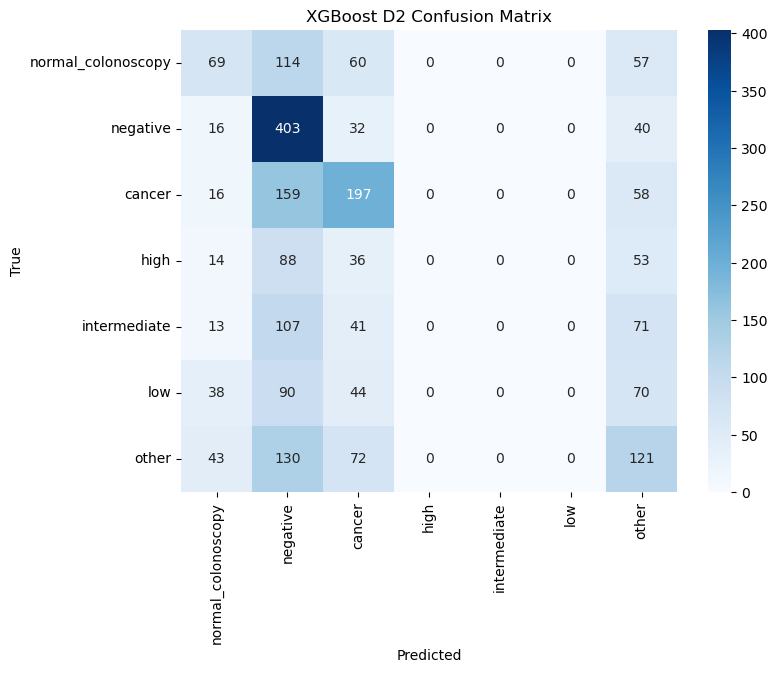

In [59]:
xgcm2 = plot_confusion_matrix_xg(model2,final_df2.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping,"XGBoost D2 Confusion Matrix")

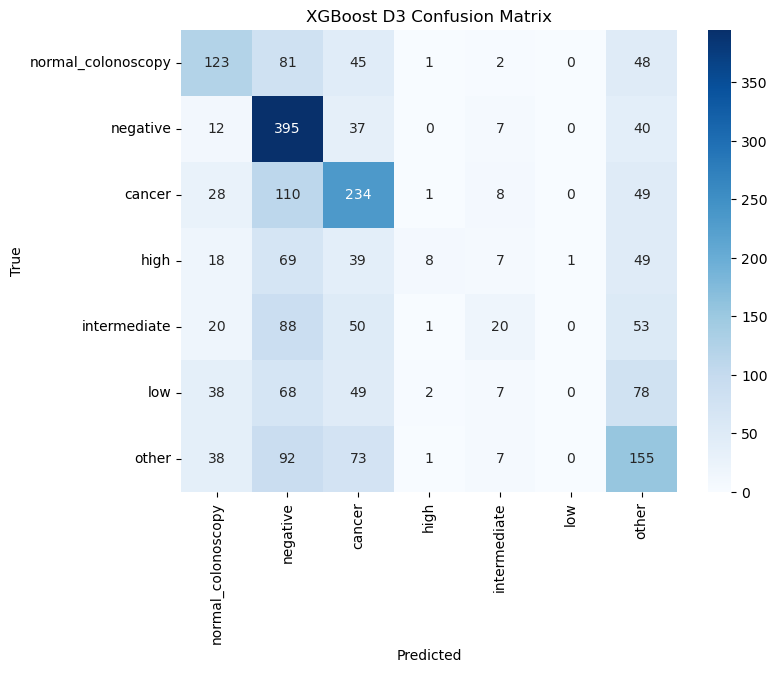

In [60]:
xgcm3 = plot_confusion_matrix_xg(model3,final_df3.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping,"XGBoost D3 Confusion Matrix")

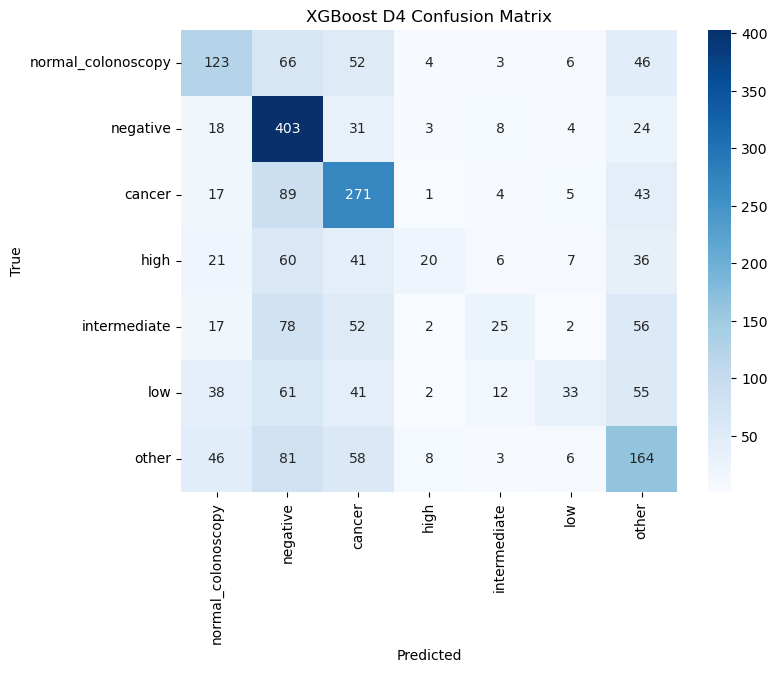

In [61]:
xgcm4 = plot_confusion_matrix_xg(model4,final_df4.drop(['Age','Gender','blood'],axis = 1),diagnosis_mapping,"XGBoost D4 Confusion Matrix")

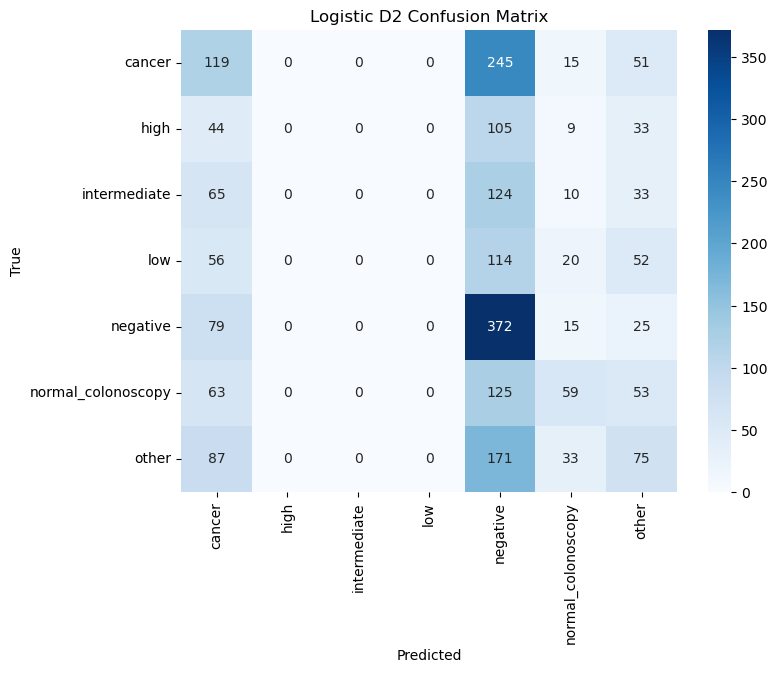

In [62]:
logcm2 = plot_confusion_matrix_log(best_model2,final_df2.drop(['Age','Gender','blood'],axis = 1),"Logistic D2 Confusion Matrix")

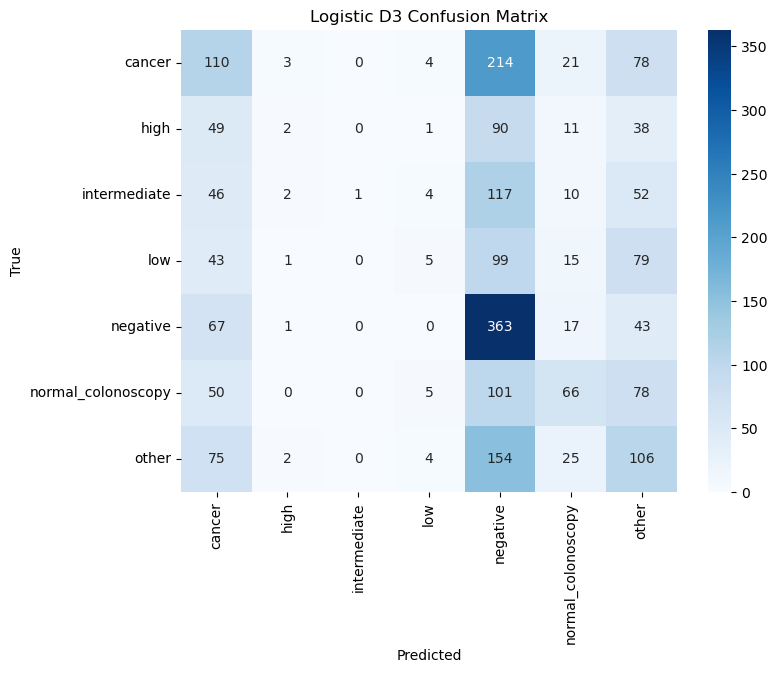

In [63]:
logcm3 = plot_confusion_matrix_log(best_model3,final_df3.drop(['Age','Gender','blood'],axis = 1),"Logistic D3 Confusion Matrix")

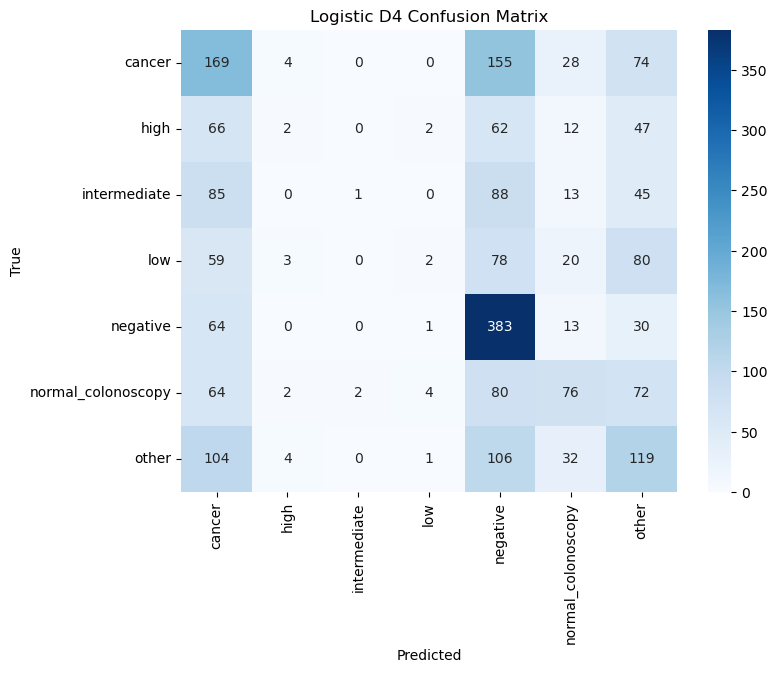

In [64]:
logcm4 = plot_confusion_matrix_log(best_model4,final_df4.drop(['Age','Gender','blood'],axis = 1),"Logistic D4 Confusion Matrix")

In [65]:
final_df2['diagnosis'].value_counts()

negative              491
cancer                430
other                 366
normal_colonoscopy    300
low                   242
intermediate          232
high                  191
Name: diagnosis, dtype: int64

In [66]:
accuracy, precision, recall, f1 = calculate_metrics(xgcm2)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.35079928952042627
Precision: [0.33014354066985646, 0.3693858845096242, 0.4087136929460581, nan, nan, nan, 0.2574468085106383]
Recall: [0.23, 0.8207739307535642, 0.45813953488372094, 0.0, 0.0, 0.0, 0.33060109289617484]
F1 Score: [0.27111984282907664, 0.5094816687737042, 0.4320175438596491, nan, nan, nan, 0.28947368421052627]


/tmp/ipykernel_20/3477855915.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(confusion_mat) / np.sum(confusion_mat, axis=0)


In [67]:
accuracy, precision, recall, f1 = calculate_metrics(xgcm3)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.41518650088809944
Precision: [0.44404332129963897, 0.4374307862679956, 0.444022770398482, 0.5714285714285714, 0.3448275862068966, 0.0, 0.3283898305084746]
Recall: [0.41, 0.8044806517311609, 0.5441860465116279, 0.041884816753926704, 0.08620689655172414, 0.0, 0.42349726775956287]
F1 Score: [0.4263431542461005, 0.5667144906743186, 0.4890282131661442, 0.07804878048780488, 0.13793103448275862, nan, 0.36992840095465396]


/tmp/ipykernel_20/3477855915.py:9: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


In [68]:
accuracy, precision, recall, f1 = calculate_metrics(xgcm4)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.4613676731793961
Precision: [0.4392857142857143, 0.4809069212410501, 0.49633699633699635, 0.5, 0.4098360655737705, 0.5238095238095238, 0.3867924528301887]
Recall: [0.41, 0.8207739307535642, 0.6302325581395349, 0.10471204188481675, 0.10775862068965517, 0.13636363636363635, 0.44808743169398907]
F1 Score: [0.4241379310344828, 0.6064710308502633, 0.5553278688524591, 0.17316017316017315, 0.1706484641638225, 0.2163934426229508, 0.4151898734177215]


In [69]:
accuracy, precision, recall, f1 = calculate_metrics(logcm2)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.2775310834813499
Precision: [0.23196881091617932, nan, nan, nan, 0.2961783439490446, 0.36645962732919257, 0.2329192546583851]
Recall: [0.27674418604651163, 0.0, 0.0, 0.0, 0.7576374745417516, 0.19666666666666666, 0.20491803278688525]
F1 Score: [0.2523860021208908, nan, nan, nan, 0.42587292501431023, 0.2559652928416486, 0.2180232558139535]


/tmp/ipykernel_20/3477855915.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(confusion_mat) / np.sum(confusion_mat, axis=0)


In [70]:
accuracy, precision, recall, f1 = calculate_metrics(logcm3)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.28996447602131437
Precision: [0.25, 0.18181818181818182, 1.0, 0.21739130434782608, 0.3189806678383128, 0.4, 0.22362869198312235]
Recall: [0.2558139534883721, 0.010471204188481676, 0.004310344827586207, 0.02066115702479339, 0.7393075356415478, 0.22, 0.2896174863387978]
F1 Score: [0.25287356321839083, 0.019801980198019802, 0.008583690987124462, 0.03773584905660377, 0.4456721915285451, 0.2838709677419355, 0.2523809523809523]


In [71]:
accuracy, precision, recall, f1 = calculate_metrics(logcm4)
print("Accuracy:", accuracy)
print("Precision:", list(precision))
print("Recall:", list(recall))
print("F1 Score:", list(f1))

Accuracy: 0.3339253996447602
Precision: [0.2765957446808511, 0.13333333333333333, 0.3333333333333333, 0.2, 0.4023109243697479, 0.3917525773195876, 0.25481798715203424]
Recall: [0.3930232558139535, 0.010471204188481676, 0.004310344827586207, 0.008264462809917356, 0.780040733197556, 0.25333333333333335, 0.3251366120218579]
F1 Score: [0.3246878001921229, 0.019417475728155338, 0.00851063829787234, 0.015873015873015872, 0.5308385308385308, 0.3076923076923077, 0.2857142857142857]


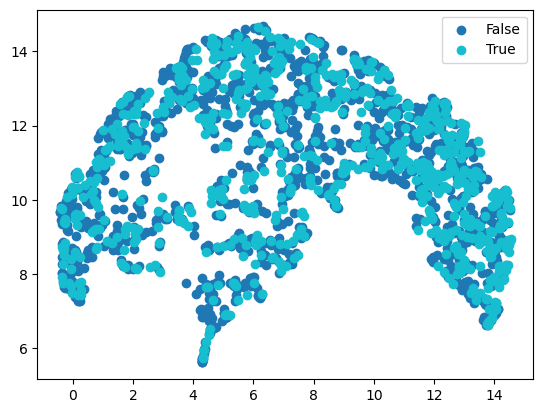

In [72]:
plot_with_color_coding(preds2.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')

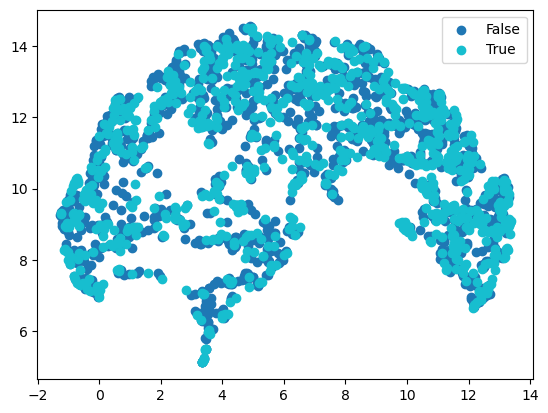

In [73]:
plot_with_color_coding(preds3.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')

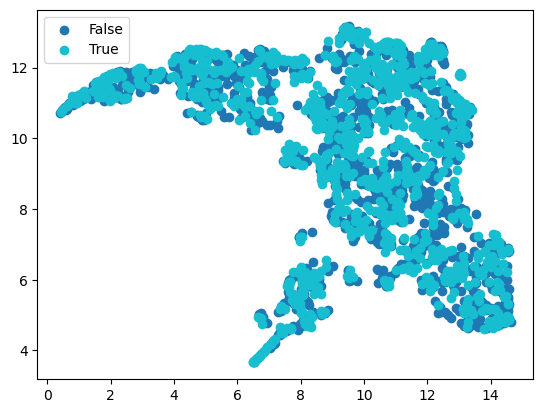

In [74]:
plot_with_color_coding(preds4.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')

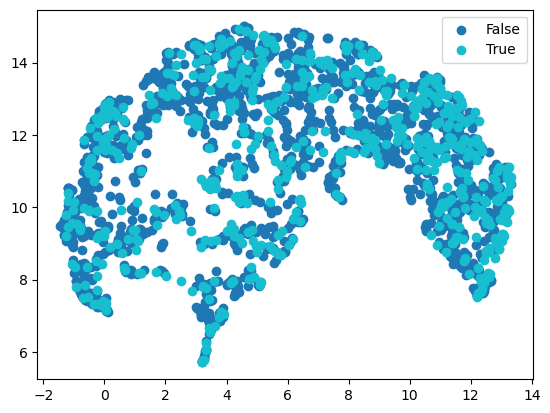

In [75]:
plot_with_color_coding(logpreds2.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')

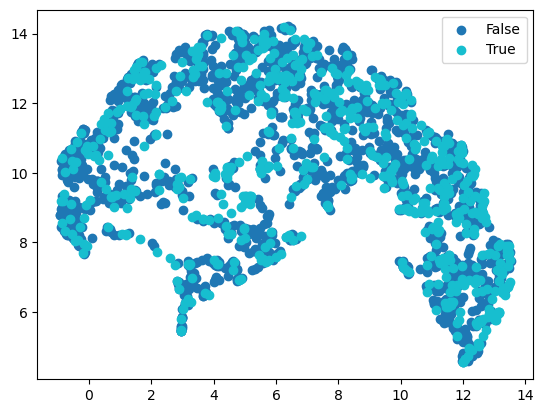

In [76]:
plot_with_color_coding(logpreds3.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')

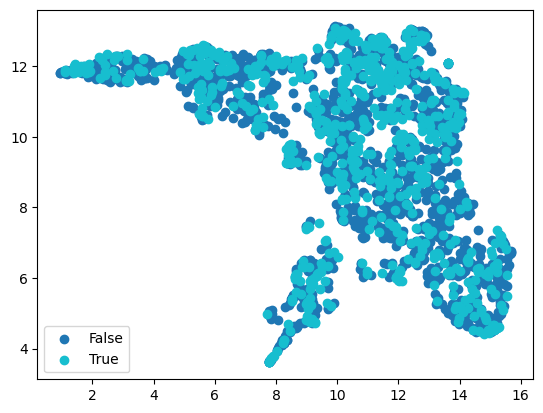

In [77]:
plot_with_color_coding(logpreds4.drop(['diagnosis','predicted_diagnosis'],axis=1),'correct_prediction')